In [24]:
import awkward as ak
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
import os
import json
import pickle

In [2]:
scale_path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
with open(f'{scale_path}/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
with open(f'{scale_path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [3]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2
xsecs['diboson_ww'] = xsecs['ww']
xsecs['diboson_wz'] = xsecs['wz']
xsecs['diboson_zz'] = xsecs['zz']

In [4]:
qcd = {}
columns = ['goodjets']
qcd_path = '/project01/ndcms/cmoore24/skims/analysis_skims/2017/trijet/mc'
for i in os.listdir(qcd_path):
    if 'qcd' in i:
        print(i)
        qcd[i] = ak.from_parquet(f'{qcd_path}/{i}/keep*', columns=columns)

ht_qcd_1000to1500
ht_qcd_1500to2000
ht_qcd_2000toInf
ht_qcd_500to700
ht_qcd_700to1000


In [37]:
def add_weights(name, arr):
    weights = {}
    lumi=41.5
    weights = ak.ones_like(arr.goodjets.msoftdrop) * (((lumi*(xsecs[name]*1000))/totals['2017'][name]))
    return weights

In [6]:
qcd_arr = ak.concatenate([qcd[i] for i in qcd]).goodjets

In [7]:
qcd_arr['weights'] = weights_arr

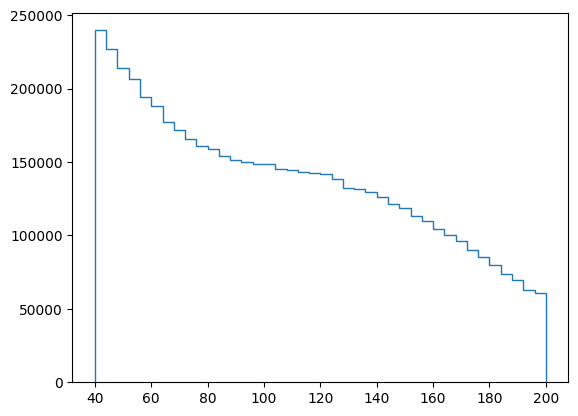

In [11]:
plt.hist(qcd_arr.msoftdrop, weights=qcd_arr.weights, bins=40, histtype='step')
plt.show()

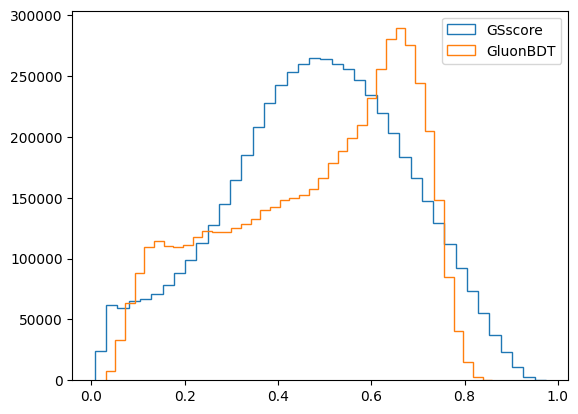

In [14]:
plt.hist(qcd_arr.GSscore, weights=qcd_arr.weights, bins=40, histtype='step', label='GSscore')
plt.hist(qcd_arr.GluonBDT, weights=qcd_arr.weights, bins=40, histtype='step',label='GluonBDT')
plt.legend()
plt.show()

In [20]:
with open('thresholds/pass_thresholds2017.pkl','rb') as f:
    pass_thresholds = pickle.load(f)

In [26]:
def apply_gsscore_cut(msoftdrop, gsscore, edges, pass_thresholds):
    m = np.asarray(ak.fill_none(msoftdrop, np.nan), dtype=np.float64)
    s = np.asarray(ak.fill_none(gsscore,   np.nan), dtype=np.float64)
    bin_idx = np.digitize(m, edges, right=True) - 1
    nb = len(edges) - 1
    inbin = (bin_idx >= 0) & (bin_idx < nb)
    thr = np.full_like(m, np.nan, dtype=float)
    thr[inbin] = pass_thresholds[bin_idx[inbin]]
    finite = np.isfinite(s)
    passed = inbin & finite & (s >= thr)
    return passed

In [46]:
# Pass tagger, fail gluon BDT
regA = {}
for i in qcd:
    gs_mask = apply_gsscore_cut(qcd[i].goodjets.msoftdrop, 
                                 qcd[i].goodjets.GSscore, 
                                 np.linspace(40, 200, 41), 
                                 pass_thresholds
                                )
    region_mask = gs_mask & (qcd[i].goodjets.GluonBDT < 0.50)
    regA[i] = qcd[i][ak.flatten(region_mask)]
for i in regA:
    regA[i]['goodjets','weights'] = add_weights(i, regA[i])
regA_arr = ak.concatenate([regA[i] for i in regA]).goodjets

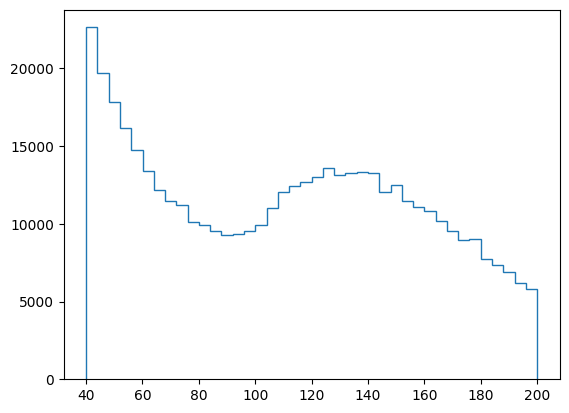

In [47]:
plt.hist(regA_arr.msoftdrop, bins=40, weights=regA_arr.weights, histtype='step')
plt.show()

In [48]:
# Pass both
regB = {}
for i in qcd:
    gs_mask = apply_gsscore_cut(qcd[i].goodjets.msoftdrop, 
                                 qcd[i].goodjets.GSscore, 
                                 np.linspace(40, 200, 41), 
                                 pass_thresholds
                                )
    region_mask = gs_mask & (qcd[i].goodjets.GluonBDT >= 0.50)
    regB[i] = qcd[i][ak.flatten(region_mask)]
for i in regB:
    regB[i]['goodjets','weights'] = add_weights(i, regB[i])
regB_arr = ak.concatenate([regB[i] for i in regB]).goodjets

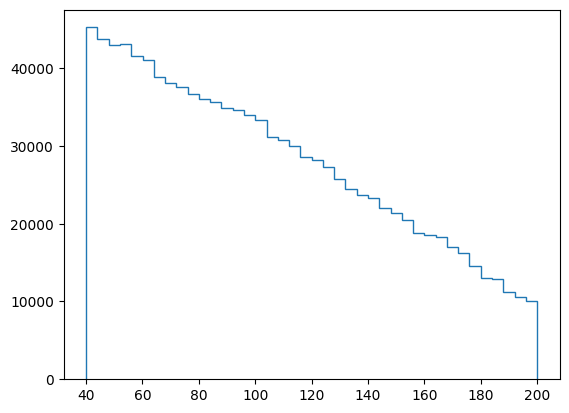

In [49]:
plt.hist(regB_arr.msoftdrop, bins=40, weights=regB_arr.weights, histtype='step')
plt.show()

In [51]:
# Fail Both
regC = {}
for i in qcd:
    gs_mask = apply_gsscore_cut(qcd[i].goodjets.msoftdrop, 
                                 qcd[i].goodjets.GSscore, 
                                 np.linspace(40, 200, 41), 
                                 pass_thresholds
                                )
    region_mask = (~gs_mask) & (qcd[i].goodjets.GluonBDT < 0.50)
    regC[i] = qcd[i][ak.flatten(region_mask)]
for i in regC:
    regC[i]['goodjets','weights'] = add_weights(i, regC[i])
regC_arr = ak.concatenate([regC[i] for i in regC]).goodjets

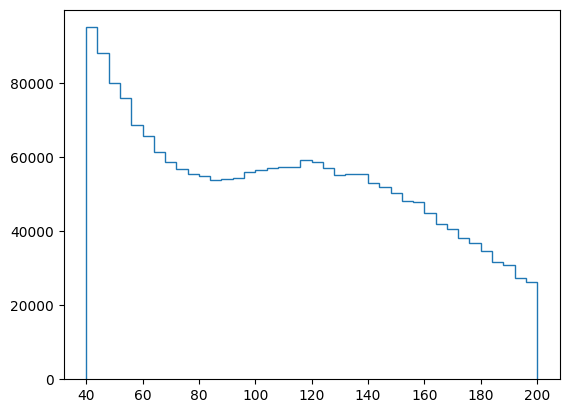

In [53]:
plt.hist(regC_arr.msoftdrop, bins=40, weights=regC_arr.weights, histtype='step')
plt.show()

In [54]:
# Fail tagger, bass gluon BDT
regD = {}
for i in qcd:
    gs_mask = apply_gsscore_cut(qcd[i].goodjets.msoftdrop, 
                                 qcd[i].goodjets.GSscore, 
                                 np.linspace(40, 200, 41), 
                                 pass_thresholds
                                )
    region_mask = (~gs_mask) & (qcd[i].goodjets.GluonBDT >= 0.50)
    regD[i] = qcd[i][ak.flatten(region_mask)]
for i in regD:
    regD[i]['goodjets','weights'] = add_weights(i, regD[i])
regD_arr = ak.concatenate([regD[i] for i in regD]).goodjets

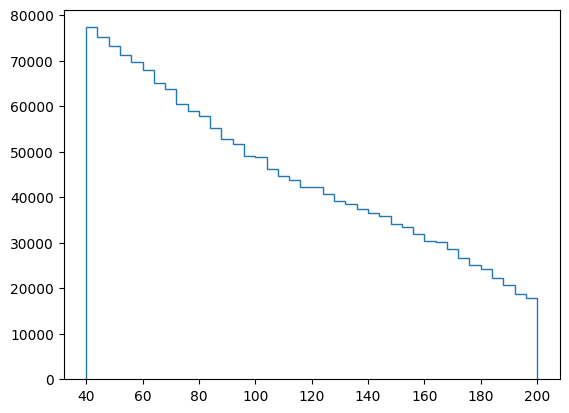

In [55]:
plt.hist(regD_arr.msoftdrop, bins=40, weights=regD_arr.weights, histtype='step')
plt.show()

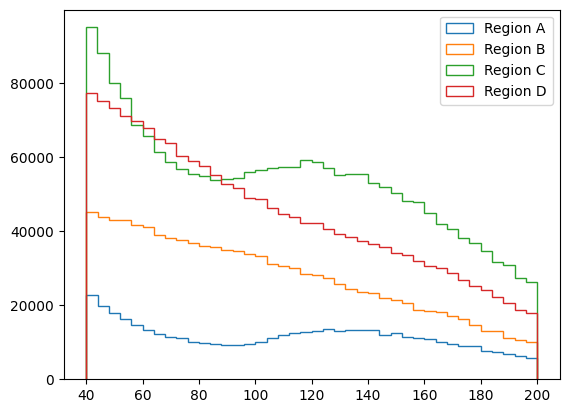

In [57]:
#All MC
plt.hist(regA_arr.msoftdrop, bins=40, weights=regA_arr.weights, histtype='step', label='Region A')
plt.hist(regB_arr.msoftdrop, bins=40, weights=regB_arr.weights, histtype='step', label='Region B')
plt.hist(regC_arr.msoftdrop, bins=40, weights=regC_arr.weights, histtype='step', label='Region C')
plt.hist(regD_arr.msoftdrop, bins=40, weights=regD_arr.weights, histtype='step', label='Region D')
plt.legend()
plt.show()